In [1]:
# import necessary libraries
import os, random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
def get_device():
    if torch.cuda.is_available(): return torch.device("cuda")
    return torch.device("cpu")

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# CIFAR10 data
def get_cifar10_loaders(batch_train=128, batch_test=256, data_dir="./data"):
    mean=(0.4914,0.4822,0.4465); std=(0.2023,0.1994,0.2010) # values obtained from running previous code for HW_1_2
    tf = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    train = torchvision.datasets.CIFAR10(root=data_dir, train=True,  download=True, transform=tf)
    test  = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=tf)
    train_loader = DataLoader(train, batch_size=batch_train, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test,  batch_size=batch_test,  shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

In [6]:
# CNN model 
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1),   nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64x16x16
            nn.Conv2d(64,128,3,padding=1),  nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128x8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
    def forward(self,x): return self.classifier(self.features(x))

In [7]:
# Train and evaluation of model
def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        tot_loss += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, correct/tot

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval().to(device)
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, correct/tot

In [8]:
# sensitivity
def batch_sensitivity(model, xb, yb, loss_fn):
    """
    Frobenius norm of d(loss)/dx, averaged over the batch.
    """
    model.eval()
    xb = xb.clone().detach().requires_grad_(True)
    logits = model(xb)
    loss = loss_fn(logits, yb)
    grad_x = torch.autograd.grad(loss, xb, create_graph=False, retain_graph=False)[0]
    per_sample = grad_x.view(grad_x.size(0), -1).norm(p=2, dim=1)
    return per_sample.mean().item()

@torch.no_grad()
def mean_sensitivity(model, loader, loss_fn, device, max_batches=5):
    """
    Average sensitivity over the first `max_batches` of `loader` for speed.
    """
    model.eval().to(device)
    total, n = 0.0, 0
    it = 0
    for xb, yb in loader:
        if it >= max_batches: break
        xb, yb = xb.to(device), yb.to(device)
        torch.set_grad_enabled(True)
        s = batch_sensitivity(model, xb, yb, loss_fn)
        torch.set_grad_enabled(False)
        total += s; n += 1; it += 1
    return total / max(1, n)

In [9]:
# Plots
def plot_dual(xvals, y_left_train, y_left_test, y_right, x_label, left_label, right_label, title, out_path):
    fig, ax1 = plt.subplots(figsize=(8.8, 5.2))
    ax1.plot(xvals, y_left_train, marker='o', label=f"train_{left_label}")
    ax1.plot(xvals, y_left_test,  marker='o', label=f"test_{left_label}", linestyle='--')
    ax1.set_xlabel(x_label); ax1.set_ylabel(left_label, color='tab:blue')
    ax1.grid(True, linewidth=0.3)
    ax2 = ax1.twinx()
    ax2.plot(xvals, y_right, marker='s', color='tab:red', label='sensitivity')
    ax2.set_ylabel(right_label, color='tab:red')
    # shared legend
    h1,l1 = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='best')
    plt.title(title)
    if isinstance(xvals, (list, tuple)) and all(v>0 for v in xvals):
        ax1.set_xscale('log')
    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=180); plt.show(); plt.close()

In [10]:
def main(
    batch_list = (32, 64, 128, 256, 512), # 5 settings
    lr = 1e-3,
    epochs=20,
    weight_decay=0.0,
    data_dir="./data",
    out_dir="HW_1-3_FlatVsGen_Part2"
):
    """
    Trains 5 models with different training approaches (varying batch size),
    records train/test loss & accuracy + sensitivity, and plots vs the chosen variable.
    """
    set_seed(42)
    dev = get_device()
    os.makedirs(out_dir, exist_ok=True)

    # fixed test loader (same for all models)
    _, test_loader_fixed = get_cifar10_loaders(data_dir=data_dir, batch_train=128, batch_test=256)

    xs = []              # x-axis values 
    train_losses = []; test_losses = []
    train_accs   = []; test_accs   = []
    sensitivities = []
    param_counts  = []

    for val in batch_list:
        train_loader, _ = get_cifar10_loaders(data_dir=data_dir, batch_train=val, batch_test=256)
        
        model = CNN().to(dev)
        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = nn.CrossEntropyLoss()

        # train
        for _ in range(epochs):
            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_fn, dev)

        # eval on common test loader
        te_loss, te_acc = evaluate(model, test_loader_fixed, loss_fn, dev)

        # sensitivity on the same fixed test loader
        sens = mean_sensitivity(model, test_loader_fixed, loss_fn, dev, max_batches=5)

        xs.append(val)
        train_losses.append(tr_loss); test_losses.append(te_loss)
        train_accs.append(tr_acc);   test_accs.append(te_acc)
        sensitivities.append(sens)
        param_counts.append(count_parameters(model))

        print(f"batch={val:4d} | params={param_counts[-1]:,d} | "
              f"train loss {tr_loss:.3f} acc {tr_acc*100:5.1f}% | "
              f"test loss {te_loss:.3f} acc {te_acc*100:5.1f}% | "
              f"sensitivity {sens:.2f}")

    # plots
    xl = "batch size (log scale)"
    plot_dual(xs, train_losses, test_losses, sensitivities, xl, "loss", "sensitivity",
              f"CIFAR-10: loss & sensitivity vs batch size",
              os.path.join(out_dir, f"loss_sensitivity_vs_batch.png"))

    plot_dual(xs, train_accs, test_accs, sensitivities, xl, "accuracy", "sensitivity",
              f"CIFAR-10: accuracy & sensitivity vs batch size",
              os.path.join(out_dir, f"acc_sensitivity_vs_batch.png"))

    return {
        "x": xs,
        "train_loss": train_losses, "test_loss": test_losses,
        "train_acc": train_accs,   "test_acc": test_accs,
        "sensitivity": sensitivities,
        "params": param_counts
    }

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
batch=  32 | params=2,360,138 | train loss 0.078 acc  97.7% | test loss 2.191 acc  75.1% | sensitivity 0.03
Files already downloaded and verified
Files already downloaded and verified
batch=  64 | params=2,360,138 | train loss 0.068 acc  97.9% | test loss 1.944 acc  75.5% | sensitivity 0.02
Files already downloaded and verified
Files already downloaded and verified
batch= 128 | params=2,360,138 | train loss 0.051 acc  98.4% | test loss 1.833 acc  75.7% | sensitivity 0.02
Files already downloaded and verified
Files already downloaded and verified
batch= 256 | params=2,360,138 | train loss 0.036 acc  98.7% | test loss 1.734 acc  75.8% | sensitivity 0.01
Files already downloaded and verified
Files already downloaded and verified
batch= 512 | params=2,360,138 | train loss 0.026 acc  99.1% | test loss 1.688 acc  76.1% | sensitivity 0.01


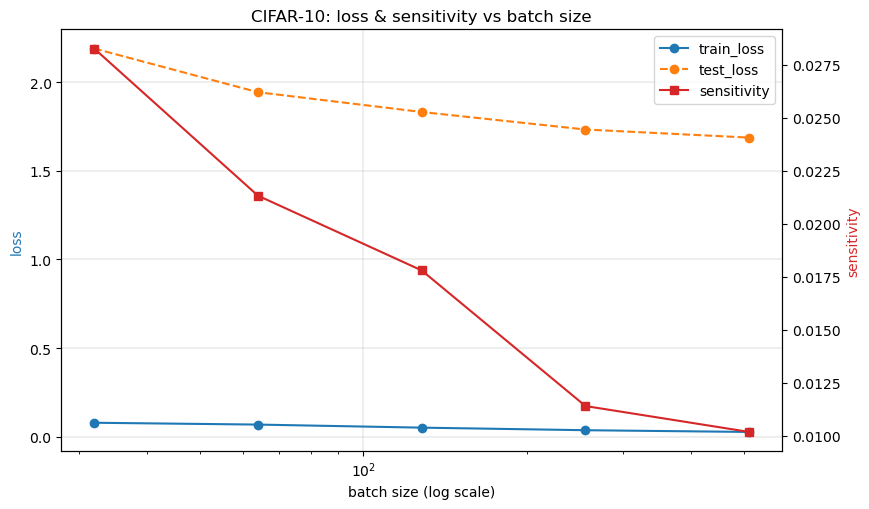

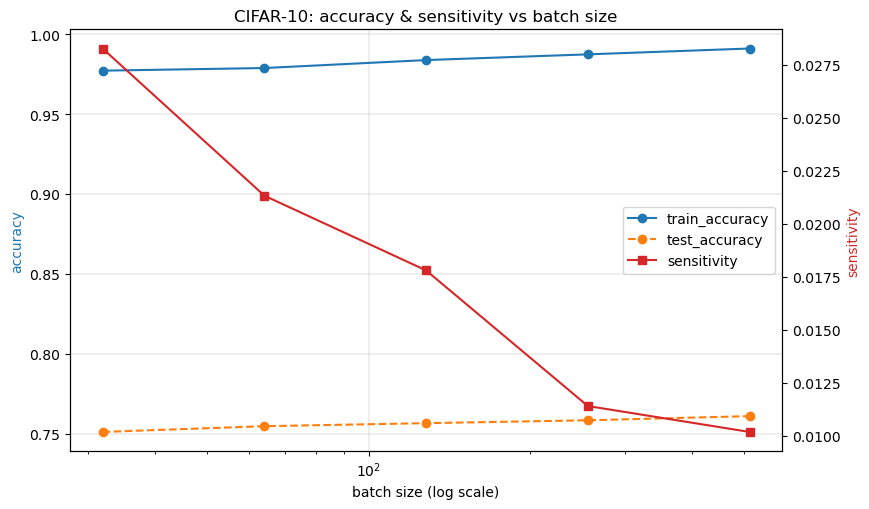

In [11]:
if __name__ == "__main__":
    main()